# LIBRARIES

In [1]:
import pickle
from Environment import Environment
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt
from ucb1_greedy import *

# ENVIRONMENT DEFINITION 

- Environment fixed informations and Products definition

In [2]:
np.random.seed(1)

products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol",
    "Amapola"
]
# Dictionary fixing the secondary products linked to 
secondary_dict= {        
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [1,3],
    "Girasol": [2,4],
    "Amapola": [2,3]
}
# Matrix n_prod*n_prices collecting the possible prices for each product. Prices are in ascending order
prices = [[8., 9, 10, 11],
          [10., 13, 16, 19],
          [20., 23, 27, 31],
          [28., 31, 35, 39],
          [40., 43, 46, 49]]
# Production cost of the products
cost = [1.3, 1.8, 2.1, 3.5, 6]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente
# Computation of margins linked to each product for a particular choice of price
cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2
# Creation of the 5 objects of Product class
for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# Parameter for the computation of the click probability on the SECOND secondary product
lambda_q = 0.7

- User Category 1: Young and Inexpert

In [3]:
# Parameters for the distribution describing the reservation price
res_price_params_1 = {
    "mean": [9, 15, 22, 33, 35],
    "std": [1, 2, 1, 1.5, 1.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_1 = [[0, 0.7, 0.3, 0, 0],
                 [0.6, 0, 0.5, 0, 0],
                 [0, 0.7, 0, 0.3, 0],
                 [0, 0, 0.4, 0, 0.1],
                 [0.5, 0, 0.3, 0, 0]]
probabilities_1 = np.matrix(probabilities_1)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_1 = [15, 15, 10, 5, 5]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_1 = 4

user1 = UserCat(alphas_1, res_price_params_1, poisson_lambda_1, probabilities_1)

- User Category 2: Old and Inexpert

In [4]:
# Parameters for the distribution describing the reservation price
res_price_params_2 = {
    "mean": [9, 16, 25, 41, 47],
    "std": [1, 2.5, 1.5, 3, 2]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_2 = [[0, 0.5, 0.4, 0, 0],
                 [0.4, 0, 0.6, 0, 0],
                 [0, 0.7, 0, 0.5, 0],
                 [0, 0, 0.5, 0, 0.3],
                 [0, 0, 0.5, 0.3, 0]]
probabilities_2 = np.matrix(probabilities_2)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_2 = [7, 12, 12, 12, 7]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_2 = 3

user2 = UserCat(alphas_2, res_price_params_2, poisson_lambda_2, probabilities_2)

- User Category 3: Expert

In [5]:
# Parameters for the distribution describing the reservation price
res_price_params_3 = {
    "mean": [8, 13, 24, 39, 50],
    "std": [1, 1.5, 2, 2, 1.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_3 = [[0, 0, 0.6, 0.4, 0],
                 [0, 0, 0, 0.7, 0.4],
                 [0, 0.4, 0, 0.6, 0],
                 [0, 0, 0.3, 0, 0.7],
                 [0, 0, 0.4, 0.6, 0]]
probabilities_3 = np.matrix(probabilities_3)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_3 = [5, 5, 10, 15, 15]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_3 = 1

user3 = UserCat(alphas_3, res_price_params_3, poisson_lambda_3, probabilities_3)

- User Category 0: Aggregated demand

In [6]:
# Parameters for the distribution describing the reservation price
res_price_params_0 = {
    "mean": [8.7, 14.7, 23.5, 37.2, 43.1],
    "std": [1, 1.5, 3, 1.5, 2]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_0 = [[0, 0.6, 0.2, 0, 0],
                 [0.5, 0, 0.4, 0, 0],
                 [0, 0.5, 0, 0.5, 0],
                 [0, 0, 0.6, 0, 0.5],
                 [0, 0, 0.3, 0.5, 0]]
probabilities_0 = np.matrix(probabilities_0)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_0 = [10, 10, 10, 10, 10]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_0 = 3

user0 = UserCat(alphas_0, res_price_params_0, poisson_lambda_0, probabilities_0)

- Environment creation

In [7]:
# list of users 
#users = [user1, user2, user3]
users = [user0]
# probability distribution of the users
#p_users = [1/3, 1/3, 1/3]
p_users = [1]

env = Environment(users, products, lambda_q, secondary_dict, p_users)

In [ ]:
env.optimal_reward()

In [ ]:
env.expected_reward([2,3,2,1,0])

In [ ]:
np.matrix(env.theoretical_values['conversion_rates'][0])

In [ ]:
np.random.seed(0)
a = env.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"])
a


In [ ]:
np.random.seed(0)
a = env.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"], aggregated= False)
a

- Reservation Price Distribution Plot for one user

In [ ]:
user_index = 0
x = np.arange(0, 60 , .01)
plt.figure(figsize=(12,7))

color_list = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(5):
    res_price_distr = env.users[user_index].res_price_distr[i]
    y = res_price_distr.pdf(x)
    plt.plot(x, y, label = 'Product %d' %i, color = color_list[i])

for i in range(5):
    for j in range(4):
        plt.scatter(prices[i][j], 0.025, color = color_list[i])

plt.title("Reservation Price Distributions for the user category %s" %env.users[user_index].category)
plt.legend()
plt.show()

# Greedy Algorithm Example

In [ ]:
greedy_optimizer = Greedy_optimizer(env)
greedy_optimizer.run()

In [ ]:
env.optimal_reward()

# STEP 3 : Uncertain Convertion Rates

In [8]:
from step3_learner import TS_learner3

In [9]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta = [a, b]
learner = TS_learner3(initial_beta, env, learning_rate = 0.5)

In [28]:
n_runs = 200
daily_users = 200
n_days = 300

# delete possible old reward_history
learner.reward_history = []
learner.price_comb_history = []
learner.cr_matrix_list = []

for i in range(n_runs) :
    learner.run(n_days, daily_users)

opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ## Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step3_rewards', 'wb') as f: 
    pickle.dump(collected_rewards, f)

- ## Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step3_rewards', 'rb') as f: 
    collected_rewards = pickle.load(f)

- ## Cumulative Regret Plot

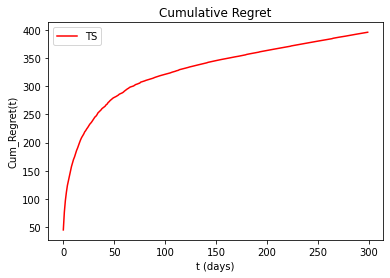

In [29]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ## Standard Deviation Plot

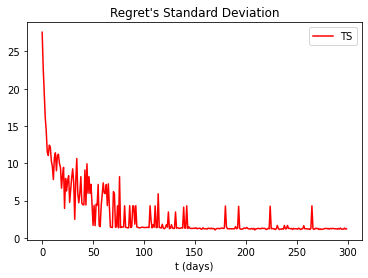

In [30]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

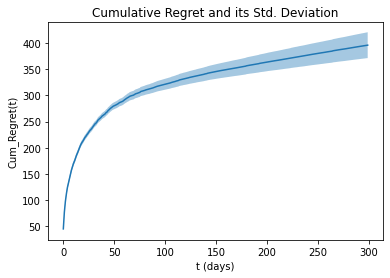

In [31]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ## Comparison between Optimal and Expected Reward

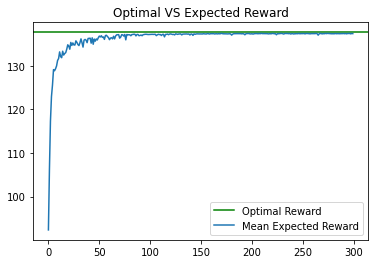

In [32]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## Explore the istant regret in the collected runs of the step 3 learner

In [ ]:
opt_reward = learner.opt_reward
(opt_reward - collected_rewards)[-2][-20:]

In [ ]:
learner.price_comb_history[-1][-20:]

## Comparison between mean conversion rates estimated by last run of TS and real values

In [15]:
CR_mean = np.array(learner.cr_matrix_list).mean(axis = 0)
i = 9
CR_i = learner.cr_matrix_list[i]
print("Mean of estimated conversion rates \n", CR_mean)

print("\nEstimated conversion rates for run %d \n" %i, CR_i)

Mean of estimated conversion rates 
 [[0.75821097 0.38717421 0.36269235 0.43911152]
 [0.72351109 0.8711801  0.19638829 0.3734326 ]
 [0.87820678 0.56892769 0.38750236 0.41816604]
 [0.81328818 0.93818612 0.92897296 0.1219864 ]
 [0.9393961  0.51383866 0.40131188 0.45651839]]

Estimated conversion rates for run 9 
 [[0.76092874 0.37278107 0.5        0.5       ]
 [0.5        0.87102271 0.17919075 0.5       ]
 [0.87795429 0.53768844 0.5        0.5       ]
 [0.5        0.99874477 0.92781111 0.15646259]
 [0.9421021  0.45132743 0.5        0.016     ]]


In [16]:
np.matrix(env.theoretical_values['conversion_rates'][0])

matrix([[0.75803635, 0.38208858, 0.09680048, 0.01072411],
        [0.99913583, 0.87146285, 0.19306234, 0.0020741 ],
        [0.8783275 , 0.56618383, 0.1216725 , 0.00620967],
        [1.        , 0.99998212, 0.92876662, 0.11506967],
        [0.93942924, 0.51993881, 0.07352926, 0.00158887]])

In [ ]:
# CODICE PER TESTARE SE UN PREZZO PER UN DETERMINATO PRODOTTO E' STATO "ESPLORATO" DALL'ALGORITMO
comb_list = learner.price_comb_history[-1]
count = 0
prod = 0
price = 0

for comb in comb_list :
    count += 1 if comb[prod] == price else 0

count

- ### ucb1 (with greedy optimizer)

In [ ]:
ucb1_greedy_R = []
ucb1g_collected_rewards = []
for _ in range(n_runs):
    ucb_greedy = ucb1_greedy(len(prices), len(prices[0]), prices, env)
    instant_regret = []
    ucb1g_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb_greedy.pull_arms()
        estimated_CR = env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])['CR_vector']
        ucb_greedy.update(pulled_arms, estimated_CR)
        reward = env.expected_reward(pulled_arms)
        ucb1g_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    ucb1g_collected_rewards.append(ucb1g_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    ucb1_greedy_R.append(cumulative_regret)

In [ ]:
# store the result
with open("ucb1_greedy_R", 'wb') as f1:
    pickle.dump(ucb1_greedy_R, f1)
with open("ucb1g_collected_rewards", 'wb') as f1:
    pickle.dump(ucb1g_collected_rewards, f1)

In [ ]:
# load the result
with open("ucb1_greedy_R", 'rb') as f1:
    ucb1_greedy_R = pickle.load(f1)
with open("ucb1g_collected_rewards", 'rb') as f1:
    ucb1g_collected_rewards = pickle.load(f1)

In [ ]:
# plot of the result
mean_ucbg_R = np.mean(ucb1_greedy_R, axis=0)
std_dev_ucbg = np.std(ucb1_greedy_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_ucbg_R)
plt.fill_between(range(n_days), mean_ucbg_R-std_dev_ucbg, mean_ucbg_R+std_dev_ucbg, alpha=0.4)

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(ucb1g_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

- ### ucb1 (brute force approach)

In [ ]:
n_runs = 2

ucb1_bforce_R = []
ucb1bf_collected_rewards = []
for _ in range(n_runs):
    ucb_brute_force = ucb1_brute_force(len(prices), len(prices[0]), prices, env)
    instant_regret = []
    ucb1bf_collected_rewards_temp = []
    for t in range(n_days):
        pulled_arms = ucb_brute_force.pull_arms()
        estimated_CR = env.simulate_day(daily_users, pulled_arms, ["conversion_rates"])['CR_vector']
        ucb_brute_force.update(pulled_arms, estimated_CR)
        reward = env.expected_reward(pulled_arms)
        ucb1bf_collected_rewards_temp.append(reward)
        instant_regret.append(opt_reward - reward)
    ucb1bf_collected_rewards.append(ucb1bf_collected_rewards_temp)
    cumulative_regret = np.cumsum(instant_regret)
    ucb1_bforce_R.append(cumulative_regret)

In [ ]:
# store the result
with open("ucb1_bforce_R", 'wb') as f1:
    pickle.dump(ucb1_bforce_R, f1)
with open("ucb1bf_collected_rewards", 'wb') as f1:
    pickle.dump(ucb1bf_collected_rewards, f1)

In [ ]:
# load the result
with open("ucb1_bforce_R", 'rb') as f1:
    ucb1_bforce_R = pickle.load(f1)
with open("ucb1bf_collected_rewards", 'rb') as f1:
    ucb1bf_collected_rewards = pickle.load(f1)

In [ ]:
# plot of the result
mean_ucbbf_R = np.mean(ucb1_bforce_R, axis=0)
std_dev_ucbbf = np.std(ucb1_bforce_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_ucbbf_R)
plt.fill_between(range(n_days), mean_ucbbf_R-std_dev_ucbbf, mean_ucbbf_R+std_dev_ucbbf, alpha=0.4)

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(ucb1bf_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

In [ ]:
to_save_data = []
d = 5
for i in range(3):
    to_save_dict = {}
    to_save_dict["CR_vector"] = np.ones((2, d))
    to_save_data.append(copy.deepcopy(to_save_dict))
final_dict = {}
final_dict["CR_vector"] = np.sum([tsd["CR_vector"] for tsd in to_save_data], axis = 0)
final_dict["CR_vector"]                                    